<a href="https://colab.research.google.com/github/linukc/planning/blob/lab5/Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Path Planning In the Environments with Dynamic Obstacles

In this lab we consider the problem of finding a (shortest) path in the environments with dynamic obstacles. The environment is represented by a grid composed of the free and blocked cells. The trajectories of dynamic obstacles are known and represented as a sequence of occupied cells in each time moment.

For simplicity it's assumed that the agent and dynamic obstacles can perform cardinal-only moves. They can also perform a wait action. All the actions have equal duration, so it's possible to discretize the timeline saying that at each time step the agent and dynamic obstacles can either move to one of the cardinal-adjacent cells or to stay in the same cell performing a wait-action.

The search-space state is described by tuple `<i, j, t>` where `i` and `j` are the cell's coordinates, `t` - time moment. So now theoretically there are an inifinite number of states corresponding to the same grid cell.

Your task is to implement A* algorithm with timesteps that avoids dynamic obstacles with known trajectories. 

In [1]:
import copy
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from heapq import heappop, heappush, heapify
from random import randint
import time
from PIL import Image, ImageDraw
from IPython.display import Image as Img
from sys import float_info
EPS = float_info.epsilon
%matplotlib notebook

In [6]:
'''Grid'''
class Map:

    # 
    def __init__(self):
        '''
        Default constructor
        '''

        self.width = 0
        self.height = 0
        self.cells = []
    

    def ReadFromString(self, cellStr, width, height):
        '''
        Converting a string (with '#' representing obstacles and '.' representing free cells) to a grid
        '''
        self.width = width
        self.height = height
        self.cells = [[0 for _ in range(width)] for _ in range(height)]
        cellLines = cellStr.split("\n")
        i = 0
        j = 0
        for l in cellLines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self.cells[i][j] = 0
                    elif c == '#':
                        self.cells[i][j] = 1
                    else:
                        continue
                    j += 1
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width )
                
                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height )
    
     
    def SetGridCells(self, width, height, gridCells):
        '''
        Initialization of map by list of cells.
        '''
        self.width = width
        self.height = height
        self.cells = gridCells


    def inBounds(self, i, j):
        '''
        Check if the cell is on a grid.
        '''
        return (0 <= j < self.width) and (0 <= i < self.height)
    

    def Traversable(self, i, j):
        '''
        Check if the cell is not an obstacle.
        '''
        return not self.cells[i][j]


    def GetNeighbors(self, i, j, diagonalMoves=False):
        '''
        Get a list of neighbouring cells as (i,j) tuples.
        '''
        candidates = {"left":{"y":i, "x":j-1, "isDiagonal":False},
                      "left_up":{"y":i+1, "x":j-1, "isDiagonal":True},
                      "up":{"y":i+1, "x":j, "isDiagonal":False},
                      "right_up":{"y":i+1, "x":j+1, "isDiagonal":True},
                      "right":{"y":i, "x":j+1, "isDiagonal":False},
                      "right_down":{"y":i-1, "x":j+1, "isDiagonal":True},
                      "down":{"y":i-1, "x":j, "isDiagonal":False},
                      "left_down":{"y":i-1, "x":j-1, "isDiagonal":True},
                      "current":{"y":i, "x":j, "isDiagonal":False}}

        candidates = {key: cell for key, cell in candidates.items() if (0 <= cell["y"] < self.height) and 
                                                                         (0 <= cell["x"] < self.width) and 
                                                                          self.Traversable(cell["y"], cell["x"])} 
     
        if not candidates.get("left"):
          candidates.pop("left_up", None)
          candidates.pop("left_down", None)
        
        if not candidates.get("right"):
          candidates.pop("right_up", None)
          candidates.pop("right_down", None)
        
        if not candidates.get("up"):
          candidates.pop("right_up", None)
          candidates.pop("left_up", None)
        
        if not candidates.get("down"):
          candidates.pop("right_down", None)
          candidates.pop("left_down", None)

        

        if diagonalMoves:
          return [(v["y"], v["x"]) for k, v in candidates.items()]
        else:
          return [(v["y"], v["x"]) for k, v in candidates.items() if not v["isDiagonal"]]

        #добавить текущее положение

### Search Node Representation



In [122]:
class Node:
    '''
    Node class represents a search node

    - i, j: coordinates of corresponding grid element
    - g: g-value of the node 
    - h: h-value of the node
    - F: f-value of the node
    - parent: pointer to the parent-node 

    You might want to add other fields, methods for Node, depending on how you prefer to implement OPEN/CLOSED further on
    '''

    def __init__(self, coord, g = 0, h = 0, F = None, parent = None):
        self.i = coord[0]
        self.j = coord[1]
        self.g = g #equals t
        self.h = h
        if F is None:
            self.F = self.g + h
        else:
            self.F = F        
        self.parent = parent
    
    
    def __eq__(self, other):
        return (self.i == other.i) and (self.j == other.j) and (self.g == other.g)
    
    def __lt__(self, other): #self < other (self has higher priority)
        return self.F < other.F or (abs(self.F - other.F) < EPS and (self.g > other.g))

    def __repr__(self):
        return f"Node-i{self.i}_j{self.j}: g {self.g} F {self.F}"

In [141]:
class OpenList ():

    def __init__(self):
        self.elements = []
    

    def __iter__(self):
        return iter(self.elements)


    def __len__(self):
        return len(self.elements)


    def isEmpty(self):
        '''
        IsEmpty should inform whether the OPEN is exhausted or not in the former case the search main loop should be interrupted
        '''
        if len(self.elements) != 0:
            return False
        return True
    
    def to_list(self):
        return self.elements

    def GetBestNode(self, *args):
        '''
        GetBestNode is the method that 
         i) finds the best node, i.e. the one with the lowest f-value (f=g+h),
         ii) removes it from OPEN and 
         iii) returns it
        '''
        #list_with_eq_g = list() #if F values equal then get g max (-> h min -> we are close to our goal)
        #bestF = math.inf
        #bestCoord = 0
        #for i in range(len(self.elements)):
        #    if self.elements[i].F <= bestF:
        #        bestCoord = i
        #        bestF = self.elements[i].F
        #        list_with_eq_g.append(self.elements[i])

        #print("---")   
        #best_ = sorted(list_with_eq_g, key=lambda node: node.g)[-1]
        #print(f"I want {best_}")

        #best = self.elements.pop(bestCoord)
        #print(f"return {best}")
        #print("---")
        best = min(self.elements, key=lambda node: (node.F, -node.g))
        index = self.elements.index(best)
        del self.elements[index]

        return best
    

    def AddNode(self, node : Node, *args):
        '''
        AddNode is the method that puts (e.g. inserts or updates) the node to OPEN
        Note that in the considered case nodes with equal coordinates but with different g-values are different states and we should save them all
        '''
        for existingNode in self.elements:
            if existingNode == node:
                return               
        self.elements.append(node)
        return


In [19]:
class YourClosed ():
    def __init__(self):
        self.elements = {}


    def __iter__(self):
        return iter(self.elements)
    

    def __len__(self):
        return len(self.elements)
    
    def to_list(self):
        return [v for k,v in self.elements.items()]

    def AddNode(self, item : Node):
        '''
        AddNode is the method that inserts the node to CLOSED
        '''
        self.elements[(item.i, item.j, item.g)] = item
     
     
    def WasExpanded(self, item : Node):
        '''
        WasExpanded is the method that checks if a node has been expanded
        '''
        return self.elements.get((item.i, item.j, item.g))

### A* with timesteps


In [11]:
def ManhattanDistance(i1, j1, i2, j2):
    return abs(i1 - i2) + abs(j1 - j2)

In [12]:
def MakePath(goal):
    '''
    Creates a path by tracing parent pointers from the goal node to the start node
    It also returns path's length.
    '''
    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [100]:
def CheckMove(i1, j1, i2, j2, t, obstacles):
    #2 type os conflicts
    for obs in obstacles:
      if t >= len(obs):
        continue
      if ((i2, j2) == obs[t]) or ((i1, j1) == obs[t] and (i2, j2) == obs[t-1]):
        return False
    return True

In [102]:
def AStarTimesteps(gridMap:Map, iStart:int, jStart:int, iGoal:int, jGoal:int, obstacles:list):

    OPEN = OpenList()
    CLOSED = YourClosed()
    OPEN.AddNode(Node((iStart, jStart), g=0, parent=None))
    max_obst_loop = max(obstacles, key=lambda x: len(x))

    while not OPEN.isEmpty():
      s = OPEN.GetBestNode() #method also delete from OPEN
      
      CLOSED.AddNode(s)
      if s.i == iGoal and s.j == jGoal:
        check_final_waiting = [CheckMove(iGoal, jGoal, iGoal, jGoal, t, obstacles) for t in range(s.g, len(max_obst_loop), 1)]
        if all(check_final_waiting):
          return (True, s, CLOSED.to_list(), OPEN.to_list())
      for i, j in gridMap.GetNeighbors(s.i, s.j, diagonalMoves=False):
        if CheckMove(s.i, s.j, i, j, s.g+1, obstacles):
          s_ = Node((i, j), g=s.g+1, h=ManhattanDistance(i, j, iGoal, jGoal), parent=s)
          if CLOSED.WasExpanded(s_):
            continue
          OPEN.AddNode(s_)

    return (False, None, CLOSED.to_list(), OPEN.to_list())

#критерий остановки новый;  check move при вызове нейборов (не будет коллизий с динамикой)

## Visualization

In [23]:
def Draw(gridMap : Map, paths : list, obstacles : list, filename = 'animated_trajectories'):
    '''
    Auxiliary function that visualizes the enviromnet, the agent and dynamic obstacles.
    '''
    k = 20
    quality = 5
    hIm = gridMap.height * k
    wIm = gridMap.width * k
    maxlen = 0
    for path in paths:
        maxlen = max(maxlen, len(path))
    step = 0
    images = []
    colors = [(randint(0,255), randint(0,255), randint(0,255)) for _ in range(len(paths))]
    while step < maxlen:
        for n in range(0, quality):
            im = Image.new('RGB', (wIm, hIm), color = 'white')
            draw = ImageDraw.Draw(im)
            for i in range(gridMap.height):
                for j in range(gridMap.width):
                    if(gridMap.cells[i][j] == 1):
                        draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=( 70, 80, 80 ))
            for i in range(len(paths)):
                curNode = paths[i][min(len(paths[i]) - 1, step)]
                nextNode = paths[i][min(len(paths[i]) - 1, step + min(n, 1))]
                draw.ellipse((float(curNode.j + n*(nextNode.j - curNode.j)/quality + 0.2) * k, 
                              float(curNode.i + n*(nextNode.i - curNode.i)/quality + 0.2) * k, 
                              float(curNode.j + n*(nextNode.j - curNode.j)/quality + 0.8) * k - 1, 
                              float(curNode.i + n*(nextNode.i - curNode.i)/quality + 0.8) * k - 1), 
                              fill=(0, 200, 200), width=0)
            for i in range(len(obstacles)):
                curNode = obstacles[i][min(len(obstacles[i]) - 1, step)]
                nextNode = obstacles[i][min(len(obstacles[i]) - 1, step + min(n, 1))]
                draw.ellipse((float(curNode[1] + n*(nextNode[1] - curNode[1])/quality + 0.2) * k, 
                              float(curNode[0] + n*(nextNode[0] - curNode[0])/quality + 0.2) * k, 
                              float(curNode[1] + n*(nextNode[1] - curNode[1])/quality + 0.8) * k - 1, 
                              float(curNode[0] + n*(nextNode[0] - curNode[0])/quality + 0.8) * k - 1), 
                              fill=(50, 50, 50), width=0)
            images.append(im)
        step += 1
    images[0].save('./'+filename+'.gif.png', save_all=True, append_images=images[1:], optimize=False, duration=500/quality, loop=0)

## Experimental evaluation

In [24]:
def SimpleTest(SearchFunction, task, heuristicFunction, *args):
    '''
    SimpleTest runs SearchFunction on one task (use a number from 0 to 5 to 
    choose a certain debug task on simple map or None to choose a random task 
    from this pool) with *args as optional arguments and displays:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     - 'Execution error' -- an error occurred while executing the SearchFunction In first two cases function also draws visualisation of the task

    Parameters:
        SearchGenerator (generator):
        task (int):

    Returns:
        pathFound (bool): Path was found or not.   
        length (Node): The length of the last found path.
    '''
    
    height = 15
    width = 30
    mapstr = '''
. . . # # . . . . . . . . # # . . . # . . # # . . . . . . .  
. . . # # # # # . . # . . # # . . . . . . # # . . . . . . . 
. . . . . . . # . . # . . # # . . . # . . # # . . . . . . . 
. . . # # . . # . . # . . # # . . . # . . # # . . . . . . . 
. . . # # . . # . . # . . # # . . . # . . # # . . . . . . . 
. . . # # . . # . . # . . # # . . . # . . # # # # # . . . . 
. . . # # . . # . . # . . # # . . . # . . # # # # # . . . . 
. . . . . . . # . . # . . # # . . . # . . # . . . . . . . . 
. . . # # . . # . . # . . # # . . . # . . # . . . . . . . . 
. . . # # . . # . . # . . # # . . . # . . # . . . . . . . . 
. . . # # . . . . . # . . . . . . . # . . . . . . . . . . . 
. . . # # # # # # # # # # # # # . # # . # # # # # # # . # # 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . .
'''

    taskMap = Map()
    taskMap.ReadFromString(mapstr, width, height)
    starts = [(1, 28), (2, 29), (3, 20), (3, 20), (0, 0)]
    goals = [(0, 1), (6, 2), (5, 6), (12, 0), (4, 23)]
    obstacles = []
    obstacles.append([(12,2), (11,2), (12,2), (13,2), (14,2), (13,2), (12,2), (11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2)])
    obstacles.append([(13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1)])    
    obstacles.append([(1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1)])
    obstacles.append([(7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2)])
    obstacles.append([(13,10), (13,11), (13,12), (13,13), (13,14), (13,15), (13,16), (13,17), (13,16), (13,15), (13,14), (13,13), (13,12), (13,11), (13,10), (13,11), (13,12), (13,13), (13,14), (13,15), (13,16), (13,17), (13,16), (13,15), (13,14), (13,13), (13,12), (13,11), (13,10), (13,11), (13,12), (13,13), (13,14), (13,15), (13,16), (13,17), (13,16), (13,15), (13,14), (13,13), (13,12), (13,11), (13,10), (13,11), (13,12), (13,13), (13,14), (13,15), (13,16), (13,17), (13,16), (13,15), (13,14), (13,13), (13,12), (13,11), (13,10), (13,11), (13,12), (13,13), (13,14), (13,15), (13,16), (13,17), (13,16), (13,15), (13,14), (13,13), (13,12), (13,11), (13,10), (13,11), (13,12), (13,13), (13,14), (13,15), (13,16), (13,17), (13,16), (13,15), (13,14), (13,13), (13,12), (13,11)])
    obstacles.append([(11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16)])
    obstacles.append([(4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0)])
    obstacles.append([(10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21)])
    obstacles.append([(12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6)])
    obstacles.append([(12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27)])
    lengths = [54, 47, 48, 37, 56]

    if (task is None) or not (0 <= task < 5):
        task = randint(0, 4)

    start = Node(starts[task])
    goal = Node(goals[task])
    length = lengths[task]


    result = SearchFunction(taskMap, start.i, start.j, goal.i, goal.j, obstacles, *args)
    nodesExpanded = result[2]
    nodesOpened = result[3]
    if result[0]:
        path = MakePath(result[1])
        correct = int(path[1])  == int(length)
        print("Path found! Length: " + str(path[1]) + ". Nodes created: " + str(len(nodesOpened) + len(nodesExpanded)) + ". Number of steps: " + str(len(nodesExpanded)) + ". Correct: " + str(correct))
        Draw(taskMap, [path[0]], obstacles)
        return Img(filename = 'animated_trajectories.gif.png')
    else:
        print("Path not found!")



Path found! Length: 54. Nodes created: 2136. Number of steps: 1636. Correct: True
CPU times: user 2.27 s, sys: 47.8 ms, total: 2.32 s
Wall time: 2.32 s


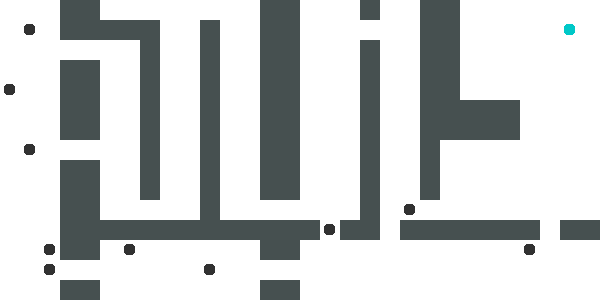

In [142]:
#Path found! Length: 54. Nodes created: 3726. Number of steps: 1614. Correct: True
#Wall time: 2.42 s
%time SimpleTest(AStarTimesteps, 0, ManhattanDistance)

Path found! Length: 47. Nodes created: 1554. Number of steps: 1180. Correct: True
CPU times: user 1.94 s, sys: 30.5 ms, total: 1.97 s
Wall time: 1.97 s


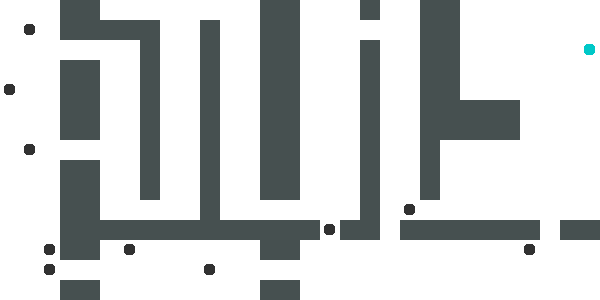

In [143]:
#Path found! Length: 47. Nodes created: 2709. Number of steps: 1168. Correct: True
#Wall time: 2.52 s
%time SimpleTest(AStarTimesteps, 1, ManhattanDistance)

Path found! Length: 48. Nodes created: 3596. Number of steps: 3095. Correct: True
CPU times: user 2.48 s, sys: 26.5 ms, total: 2.51 s
Wall time: 2.52 s


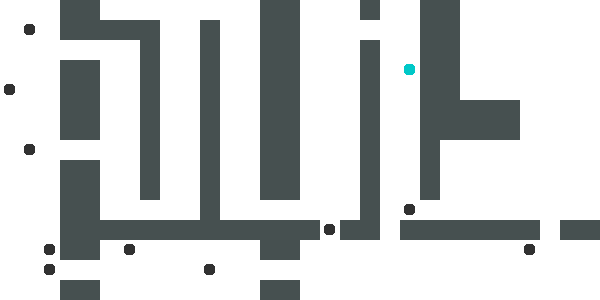

In [144]:
%time SimpleTest(AStarTimesteps, 2, ManhattanDistance)

Path found! Length: 37. Nodes created: 667. Number of steps: 441. Correct: True
CPU times: user 1.47 s, sys: 23.7 ms, total: 1.49 s
Wall time: 1.49 s


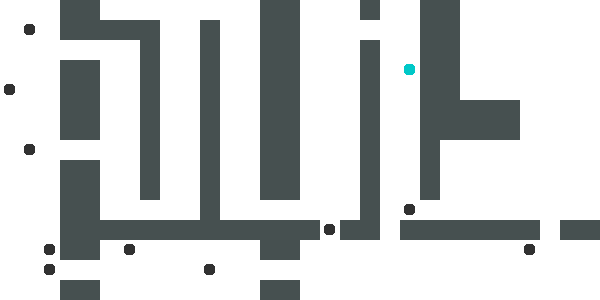

In [145]:
%time SimpleTest(AStarTimesteps, 3, ManhattanDistance)

Path found! Length: 56. Nodes created: 3272. Number of steps: 2767. Correct: True
CPU times: user 2.77 s, sys: 41.6 ms, total: 2.81 s
Wall time: 2.82 s


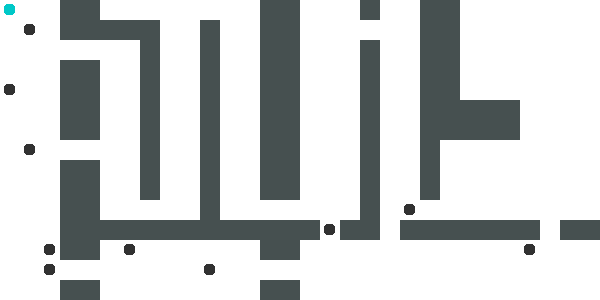

In [146]:
%time SimpleTest(AStarTimesteps, 4, ManhattanDistance)